In [1]:
import os
import sys
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True



In [2]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
---
matplotlib version: 3.10.0
pandas version: 2.2.3
PIL version: 11.1.0
torch version: 2.7.0+cpu
torchvision version: 0.22.0+cpu


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


# Build a transformer pipeline

In [4]:
class convertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [5]:
transform = transforms.Compose([
      convertToRGB(),
      transforms.Resize((200, 200)),
      transforms.ToTensor()
]
)

In [6]:
os.getcwd()

'C:\\Users\\MonsuratAyinde\\Desktop\\CNN'

In [7]:
data_dir = "safari/"
train_dir = os.path.join(data_dir, "training")

print("Will read data from", train_dir)

Will read data from safari/training


In [8]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [9]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['elephant', 'giraffe', 'lion', 'zebra']
That's 4 classes

Tensor shape for one image:
torch.Size([3, 200, 200])


# Create a DataLoader that loads from this DataSet in batches of 32.

In [10]:

batch_size = 32
dataset_loader = DataLoader(dataset, batch_size = batch_size)

# get one batch
first_batch = next(iter(dataset_loader))
print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 200, 200])
Shape of labels: torch.Size([32])


# Transform the Data

Our images are all the same shape, and have been converted to tensors. But neural networks tend to perform best with data that has a mean of  
0 and a standard deviation of 1

In [11]:
def get_mean_std(loader):
    channel_sum, channel_squared_sum, num_batches = 0,0,0
    for data, _ in tqdm(loader):
        channel_sum += torch.mean(data, dim=[0, 2, 3])
        channel_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    # Compute the mean from the channels_sum and num_batches
    mean = channel_sum/num_batches
     # Compute the standard deviation form channels_squared_sum, num_batches,
    # and the mean
    std = (channel_squared_sum/num_batches - mean** 2) ** 2
    return mean, std

mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

  0%|          | 0/13 [00:00<?, ?it/s]

Mean: tensor([0.9348, 0.9227, 0.8904])
Standard deviation: tensor([0.0015, 0.0019, 0.0058])


# Build a new transformer pipeline that normalizes the channels according to the mean and standard deviation above.

In [12]:
transform_norm = transforms.Compose([
    convertToRGB(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

print(transform_norm)




Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.9348, 0.9227, 0.8904]), std=tensor([0.0015, 0.0019, 0.0058]))
)


# Make a new normalized dataset using ImageFolder and a new DataLoader

In [13]:
norm_dataset = datasets.ImageFolder(root = train_dir, transform = transform_norm)
norm_loader = DataLoader(dataset = norm_dataset, batch_size = 32)

# Train and validation splitting

Use random_split to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Remember to use the normalized data

In [14]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, test_dataset = random_split(norm_dataset, [0.8, 0.2])
length_train = len(train_dataset)
length_test = len(test_dataset)
length_dataset= len(norm_dataset)

percent_train = np.round(100 * length_train/length_dataset, 2)
percent_test = np.round(100 * length_test/length_dataset, 2)

print("Training data set size:", len(train_dataset))
print("Test data set size:", len(test_dataset))

print(f'the size of train dataset is {percent_train}%, of full data')
print(f'the size of test dataset is {percent_test}%, of full data')

Training data set size: 317
Test data set size: 79
the size of train dataset is 80.05%, of full data
the size of test dataset is 19.95%, of full data


# Visualize the data with Barchart


In [15]:
def class_counts(dataset_subset):
    c = Counter(x[1] for x in tqdm(dataset_subset))
    class_to_index = dataset_subset.dataset.class_to_idx
    return pd.Series({class_name: c[idx] for class_name, idx in class_to_index.items()})

In [16]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/317 [00:00<?, ?it/s]

elephant    83
giraffe     80
lion        76
zebra       78
dtype: int64

# Create a bar plot from these counts.

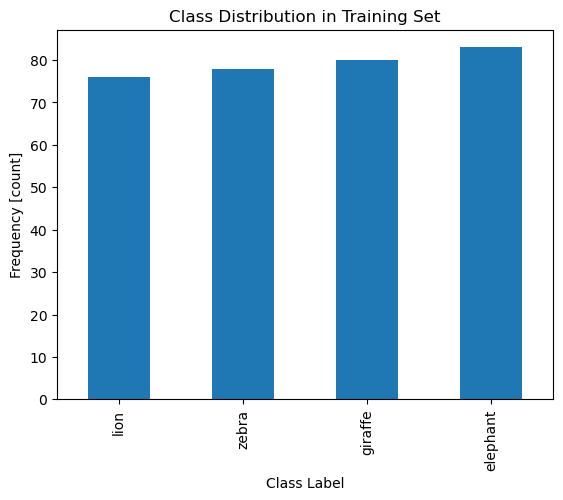

In [17]:
train_class_distributions.sort_values().plot(kind = "bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/79 [00:00<?, ?it/s]

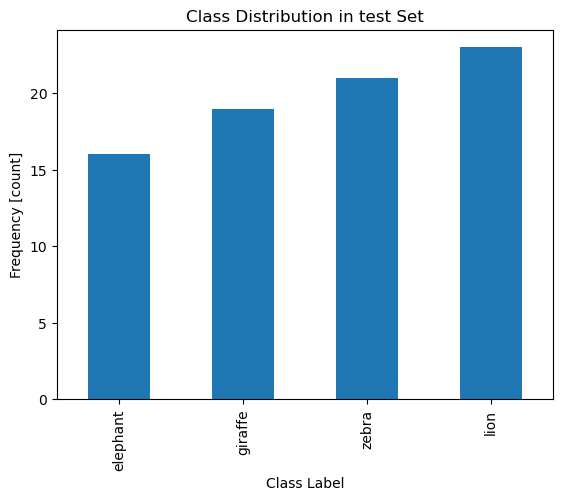

In [18]:
# Get the class distribution
test_class_distributions = class_counts(test_dataset)

# Create a bar plot from train_class_distribution
test_class_distributions.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in test Set");

# Create data loaders for the train and validation sets. Use a batch size of 32
 

In [19]:
g = torch.Generator()
g.manual_seed(42)

batch_size= 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 200, 200])


# Build the Model

In [20]:
import torch
import torch.nn as nn

model = torch.nn.Sequential()

# First Convolutional Block
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3), stride=1, padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2))  # This reduces 200x200 → 100x100
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

# Second Convolutional Block
conv2 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), stride=1, padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2))  # 100x100 → 50x50
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

# Third Convolutional Block with Dropout2d
conv3 = torch.nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), stride=1, padding=1)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout2d(p=0.2))  # Applies dropout per channel

# Flatten and Fully Connected Layers
model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout(p=0.5))  # Additional dropout before FC layer

# 24 channels × 50 × 50 from final conv output
linear1 = torch.nn.Linear(in_features=24 * 50 * 50, out_features=4)
model.append(linear1)


Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=60000, out_features=4, bias=True)
)

In [21]:
height, width = 200, 200
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Conv2d: 1-1                            [32, 12, 200, 200]        336
├─ReLU: 1-2                              [32, 12, 200, 200]        --
├─MaxPool2d: 1-3                         [32, 12, 100, 100]        --
├─Conv2d: 1-4                            [32, 12, 100, 100]        1,308
├─ReLU: 1-5                              [32, 12, 100, 100]        --
├─MaxPool2d: 1-6                         [32, 12, 50, 50]          --
├─Conv2d: 1-7                            [32, 24, 50, 50]          2,616
├─ReLU: 1-8                              [32, 24, 50, 50]          --
├─Dropout2d: 1-9                         [32, 24, 50, 50]          --
├─Flatten: 1-10                          [32, 60000]               --
├─Dropout: 1-11                          [32, 60000]               --
├─Linear: 1-12                           [32, 4]                   240,004
Tot

In [22]:
from training import predict, train

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=60000, out_features=4, bias=True)
)

# Train model for 8 epochs

In [24]:
train(model, optimizer, loss_fn, train_loader, test_loader, epochs =8, device=device)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 8.09, Validation Loss: 0.27, Validation accuracy = 0.91


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.09, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.02, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.00, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.01, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.00, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.00, Validation Loss: 0.00, Validation accuracy = 1.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.00, Validation Loss: 0.00, Validation accuracy = 1.00


In [25]:
# # Save the model weights
# model_file = 'animal_classifier.pt'
# torch.save(model.state_dict(), model_file)
# del model
# print('model saved as', model_file)

In [26]:
torch.save(model, "model/animal_classifier.pth")

In [27]:
model = torch.load("model/animal_classifier.pth", weights_only=False)